In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, recall_score, average_precision_score, precision_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, TunedThresholdClassifierCV
import matplotlib.pyplot as plt

In [2]:
import sklearn
print(sklearn.__version__)

1.7.2


# Data Cleaning

Before we can make our Random Forest model, we transform the data to be in the form the classifier wants it. 

First, we need to encode our categorical data: I have used One Hot Encoding in my Pipeline. We also need to either remove or impute NaN values - as seen in the evidence document, the proportion of rows with NaN values is only 4.23% in our training dataset and 2.74% in the testing data, so I decided to remove these values for the sake of data integrity. Finally, during modelling I removed "unknown" from smoking, as this adds no valuable information and could encourage overfitting.

Next, we seperate the label 'stroke' from the features and seperate out our X and y for our models. Also note here I've removed the column "id" as this is a randomly assigned value and will cause overfitting/noise. 

In [3]:
training_dataset = pd.read_csv('stroke_training_dataset-copy.csv')

def remove_anomolies(dataset):
    dataset = dataset.dropna()
   # dataset = dataset[dataset["gender"] != "Other"]
    dataset = dataset[dataset["smoking_status"] != "Unknown"]
    return dataset

training_dataset = remove_anomolies(training_dataset)

X_train = training_dataset.drop(['stroke', 'id'], axis=1)
y_train = training_dataset['stroke']

In [4]:
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numeric_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Random Forest Model (Baseline)
Now we can move onto building the model by a Pipeline. Note that I've set a seed to keep results consistent throughout runs and set number of trees as 500, since more trees generally means a better performing model.

In [5]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=500)

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('baseline_model', rf)
])

## Cross Validation
Now I am cross validating the training data to see how the baseline random forest model reacts to unseen data. This should give a glimpse of how it would perform on the test data. I use stratified sampling to make sure each 'test' data has an equal proportion of stroke and non-stroke cases.

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=cv, scoring='average_precision')

print("Cross-validation AUPRC scores for each fold:", np.round(cv_scores, 4))
print("Mean AUPRC across folds:", round(np.mean(cv_scores), 4))
print("Standard deviation:", round(np.std(cv_scores), 4))

Cross-validation AUPRC scores for each fold: [0.1808 0.1715 0.1337 0.1387 0.1523]
Mean AUPRC across folds: 0.1554
Standard deviation: 0.0183


The AUPRC across all of the folds is quite consistent with a fairly low standard deviation, indicating that the RF model is stable ie. performs the same on different data samples, so we can expect roughly the same when we find the performance metric (precision recall) using our real test data. 

## Random Forest (Baseline) Evaluation

Due to the imbalance (a very small proportion of positive cases) and context of our data (it's more important to correctly identify positive cases as these are people likely to have a stroke), we chose Precision-Recall as our performance metric. 

First, I am going to find the proportion of positive cases in our data, as this is the baseline for the AU-PRC. ie If we just guessed randomly each time, we would be correct this proportion of the time, so a value any higher than this indicates the model's success. 

In [7]:
print("Proportion of stroke cases in dataset:", np.mean(y_train))

Proportion of stroke cases in dataset: 0.05203371198241114


Here I've made a function to give us the precision-recall curves and AU-PRC for multiple splits of our training data, as well as the average AU-PRC for comparing versions of the model. First, I will test the baseline RF model.

In [8]:
def evaluate_pr_cross_val(model, X, y, n_splits):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.ravel()

    fold = 1
    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_proba = model.predict_proba(X_val_fold)[:, 1]

        precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_proba)
        auprc = auc(recalls, precisions)
        scores.append(auprc)

        ax = axes[i]
        ax.plot(recalls, precisions)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Fold {fold} — AUPRC: {round(auprc, 5)}')
        ax.grid(True)

        fold += 1

    for j in range(fold - 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    print(f"\nMean AUPRC across {n_splits} folds: {round(np.mean(scores), 5)}")


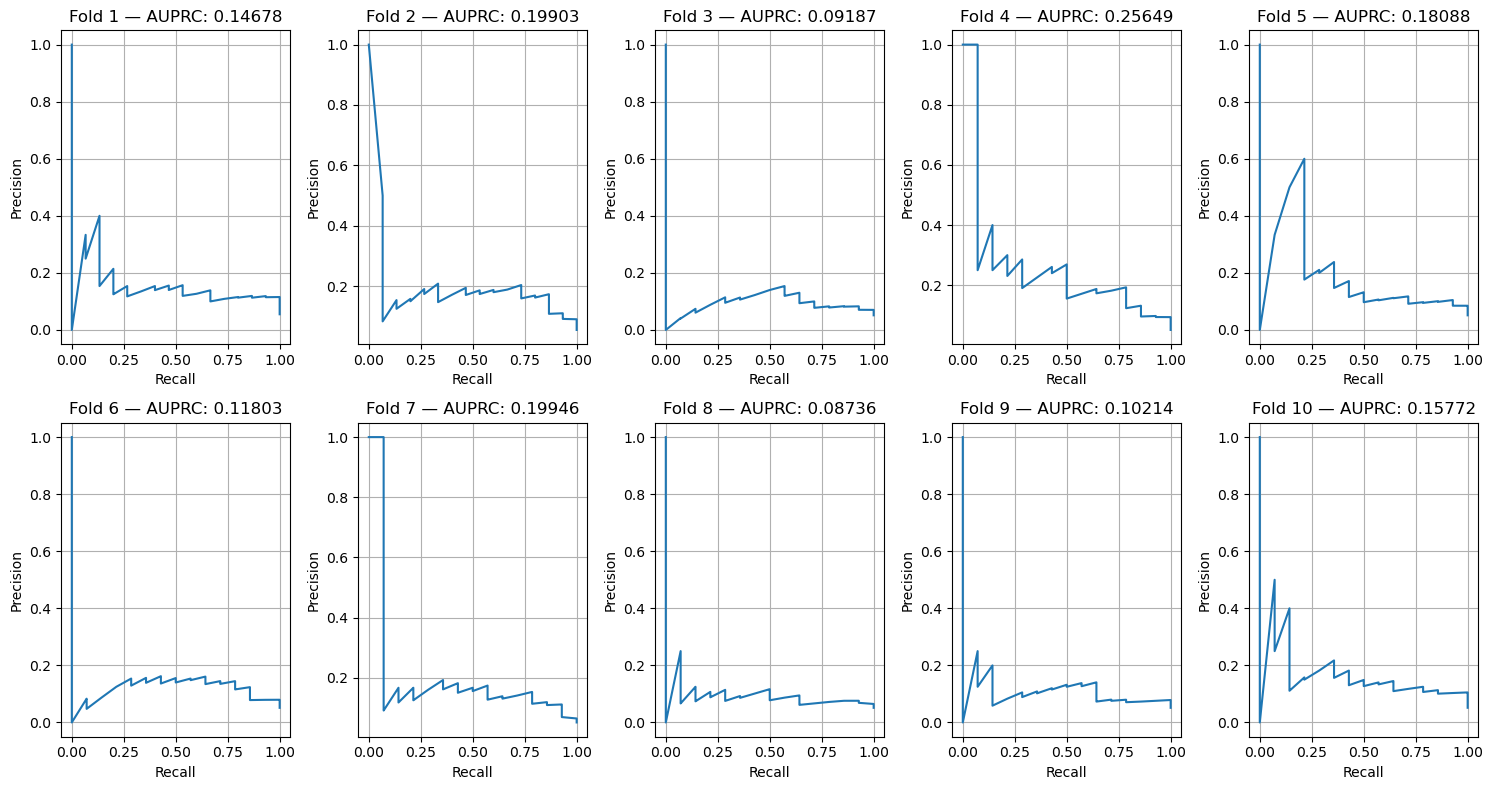


Mean AUPRC across 10 folds: 0.15397


In [9]:
evaluate_pr_cross_val(rf_pipeline, X_train, y_train, 10)

# Model Refinement
Our base AU-PRC of 0.15 is not bad by any means - around 3x more accurate than random guessing. However, there are many ways we can use our training data to 'train' our model in hopes of a better performance metric.

## Feature Selection
The first method I am considering to refine the model is feature selection. First, we need to fit our model on the entire training dataset rather than the stratified samples. Then, we find the importance of each feature based on the training data only. Since these have been one-hot encoded, I created a function to sort them back into their original features and then remove unselected features from training data.

In [10]:
rf_pipeline.fit(X_train, y_train)

rf_model = rf_pipeline.named_steps['baseline_model']

encoded_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = np.concatenate([encoded_features, numeric_features])

Importance by Feature

base_feature
avg_glucose_level    0.267000
age                  0.238019
bmi                  0.224934
smoking_status       0.056388
work_type            0.053473
Residence_type       0.039489
gender               0.037537
heart_disease        0.031244
hypertension         0.030551
ever_married         0.021364
Name: importance, dtype: float64

Selected features:
Index(['avg_glucose_level', 'age', 'bmi', 'smoking_status', 'work_type',
       'Residence_type', 'gender', 'heart_disease', 'hypertension'],
      dtype='object', name='base_feature')


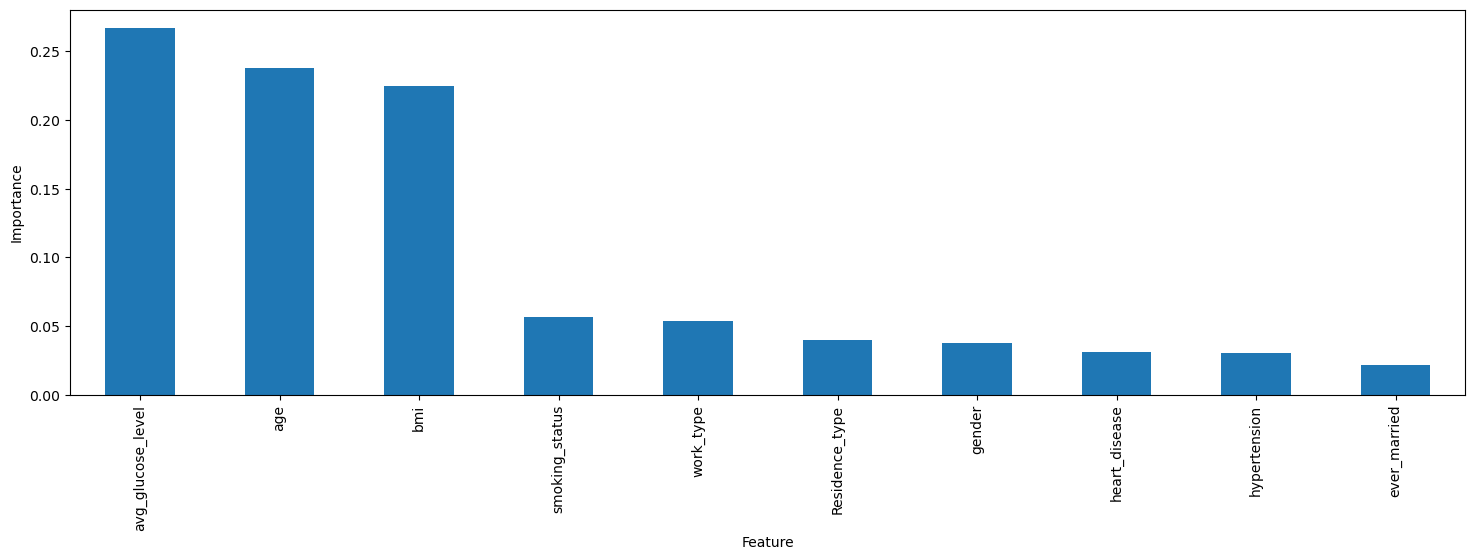

In [11]:
importances = pd.DataFrame({
    'feature': all_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

def sort_features(name):
    if name.startswith('work_type_'):
        return 'work_type'
    elif name.startswith('Residence_type_'):
        return 'Residence_type'
    elif name.startswith('smoking_status_'):
        return 'smoking_status'
    elif name.startswith('ever_married_'):
        return 'ever_married'
    elif name.startswith('gender_'):
        return 'gender'
    else:
        return name

importances['base_feature'] = importances['feature'].apply(sort_features)
grouped = importances.groupby('base_feature')['importance'].sum().sort_values(ascending=False)

print("Importance by Feature\n")
print(grouped)

grouped.head(10).plot(kind='bar', figsize=(18, 5), ylabel='Importance', xlabel='Feature')
importance_threshold = 0.025
selected_features = grouped.loc[grouped >= importance_threshold].index

print("\nSelected features:")
print(selected_features)

In [12]:
X_train_after_feature_selection = X_train[selected_features]
X_train_after_feature_selection.head()

,avg_glucose_level,age,bmi,smoking_status,work_type,Residence_type,gender,heart_disease,hypertension
0,228.69,67.0,36.6,formerly smoked,Private,Urban,Male,1,0
2,105.92,80.0,32.5,never smoked,Private,Rural,Male,1,0
3,171.23,49.0,34.4,smokes,Private,Urban,Female,0,0
4,174.12,79.0,24.0,never smoked,Self-employed,Rural,Female,0,1
5,70.09,74.0,27.4,never smoked,Private,Rural,Male,1,1


Now, I can construct a slightly ammended pipeline with the reduced features and see if the refined model has a higher precision-recall. I'm creating a new RandomForestClassifier to ensure no data leakage from the model with full feature selection. 

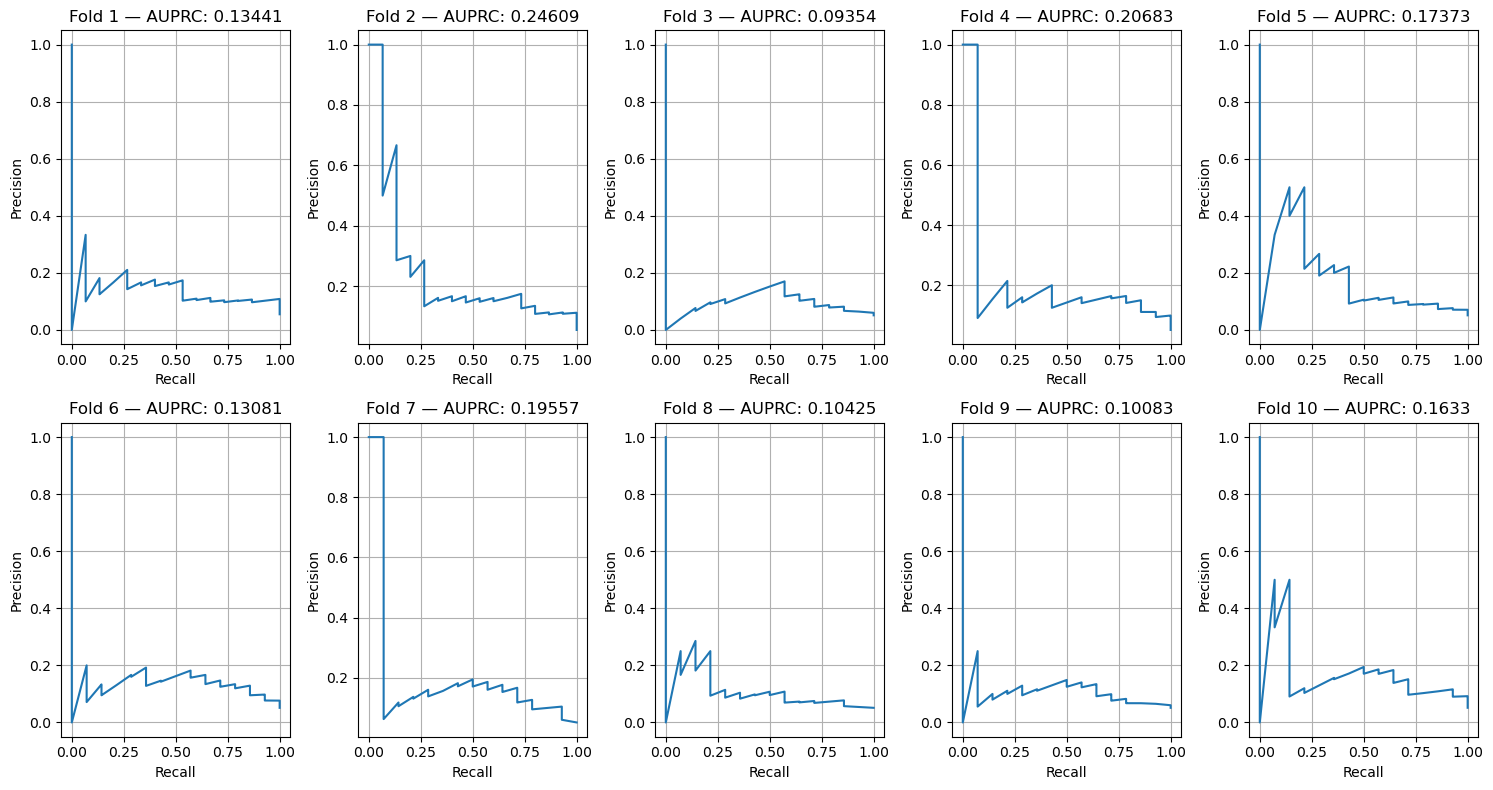


Mean AUPRC across 10 folds: 0.15494


In [13]:
selected_categorical_features = ['gender', 'work_type', 'Residence_type', 'smoking_status']
selected_numeric_features = ['age', 'hypertension', 'avg_glucose_level', 'bmi', 'heart_disease']

preprocessor_features_selected = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), selected_categorical_features)
    ],
    remainder='passthrough'
)

rf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=500)

rf_features_selected_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor_features_selected),
    ('baseline_model', rf)
])

evaluate_pr_cross_val(rf_features_selected_pipeline, X_train_after_feature_selection, y_train, 10)

Our refined model, with the lowest-importance feature (ever_married) removed, only mariginally improved our precision–recall score from the baseline model (the same to one decimal place). This suggests that ever_married contributes little independent predictive power and that feature selection did not meaningfully improve model performance in this case. 

This outcome can be explained by the mechanism behind the Random Forest algorithm: since the model aggregates predictions from many decorrelated decision trees built on random subsets of features, it has low sensitivty to the removal of weak or redundant variables. During testing, I varied the feature importance threshold between 0.05 and 0.025, excluding several low-importance predictors, and found that the AUC-PR barely changed, reaching a minimum of 0.145. This stability further supports the interpretation that the Random Forest is relatively insensitive to noise and the exclusion of minor features.

## Hyperparameter Tuning
The performance of our random forest model is heavily sensitive to the combination of hyperparameters selected, since they control the bias-variance trade off. Hyperparameters like 'max_depth' and 'min_samples_leaf' are controlled to find the value balancing between overfitting and generalisation.

Luckily, sklearn has a feature called GridSearchCV which allows us to exhaustively search through many combinations of these parameters and selects the optimal one. Note that I selected 'average_precision' since our metric is precision-recall and we are working with imbalanced data.

First, I am running this on a new Random Forest model without the feature selection done, then on the model with feature selection, so that I can compare which is the better refinement technique (in hindsight it will obviously be this one due to feature selection's diminishing results) and whether they work well in combination.

## Experimenting 
Here, I am going to experiment with prioritising 'recall' vs 'precision' in my hyper parameter tuning and see how it affects my AU-PRC and type 2 error rate.

In [14]:
# Recall

param_grid = {
    'baseline_model__n_estimators': [100, 200, 300],
    'baseline_model__max_depth': [5, 10, None],
    'baseline_model__min_samples_split': [2, 5, 10],
    'baseline_model__min_samples_leaf': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=10,
    scoring='recall',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'baseline_model__max_depth': None, 'baseline_model__min_samples_leaf': 1, 'baseline_model__min_samples_split': 2, 'baseline_model__n_estimators': 100}


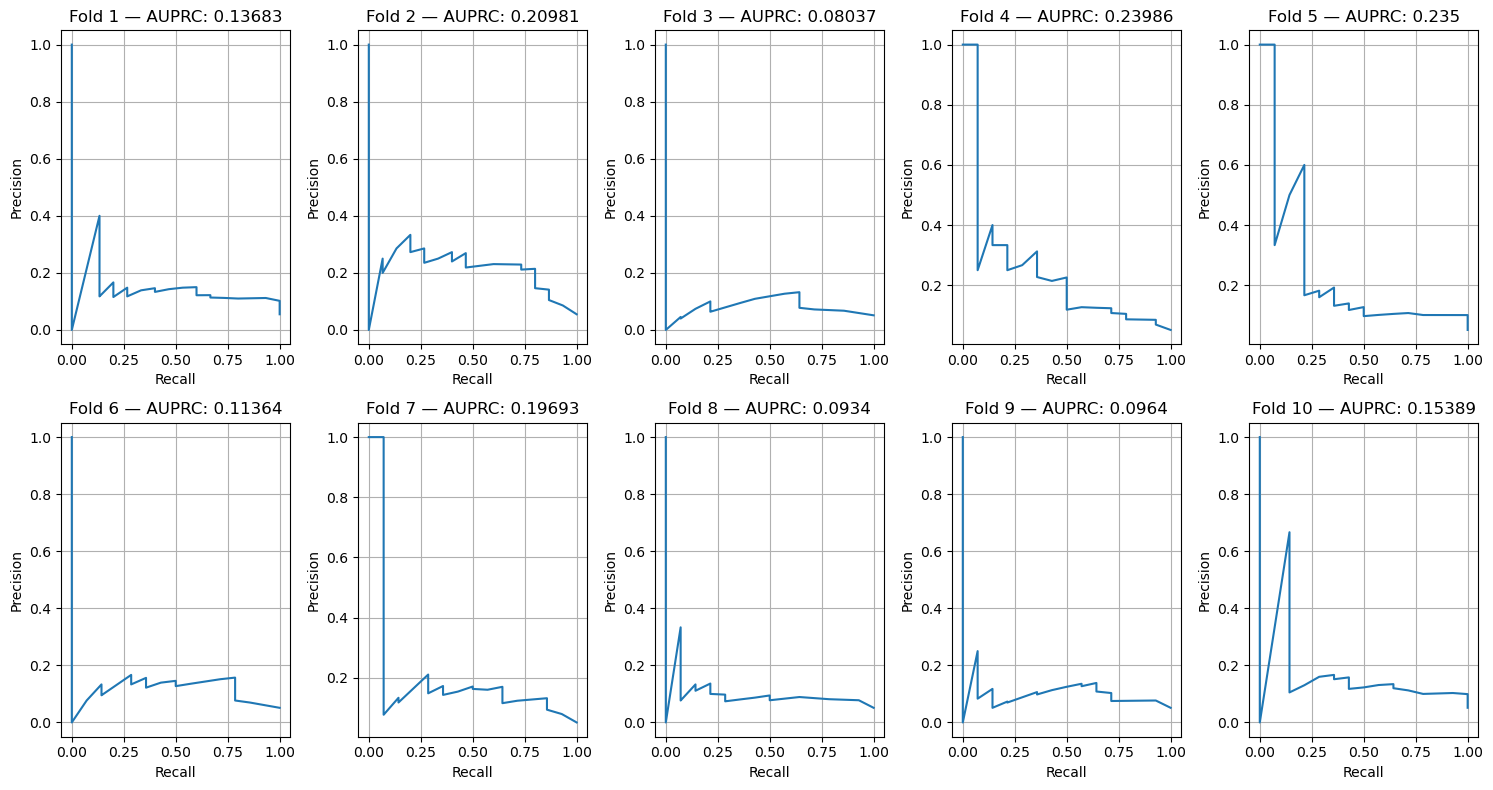


Mean AUPRC across 10 folds: 0.15562


In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

rf_recall = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=100, min_samples_leaf=1, min_samples_split=2, max_depth=None)

rf_recall_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('baseline_model', rf_recall)
])

evaluate_pr_cross_val(rf_recall_pipeline, X_train, y_train, 10)

In [16]:
# Precision

param_grid = {
    'baseline_model__n_estimators': [100, 200, 300],
    'baseline_model__max_depth': [5, 10, None],
    'baseline_model__min_samples_split': [2, 5, 10],
    'baseline_model__min_samples_leaf': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=10,
    scoring='average_precision',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'baseline_model__max_depth': 5, 'baseline_model__min_samples_leaf': 3, 'baseline_model__min_samples_split': 2, 'baseline_model__n_estimators': 200}


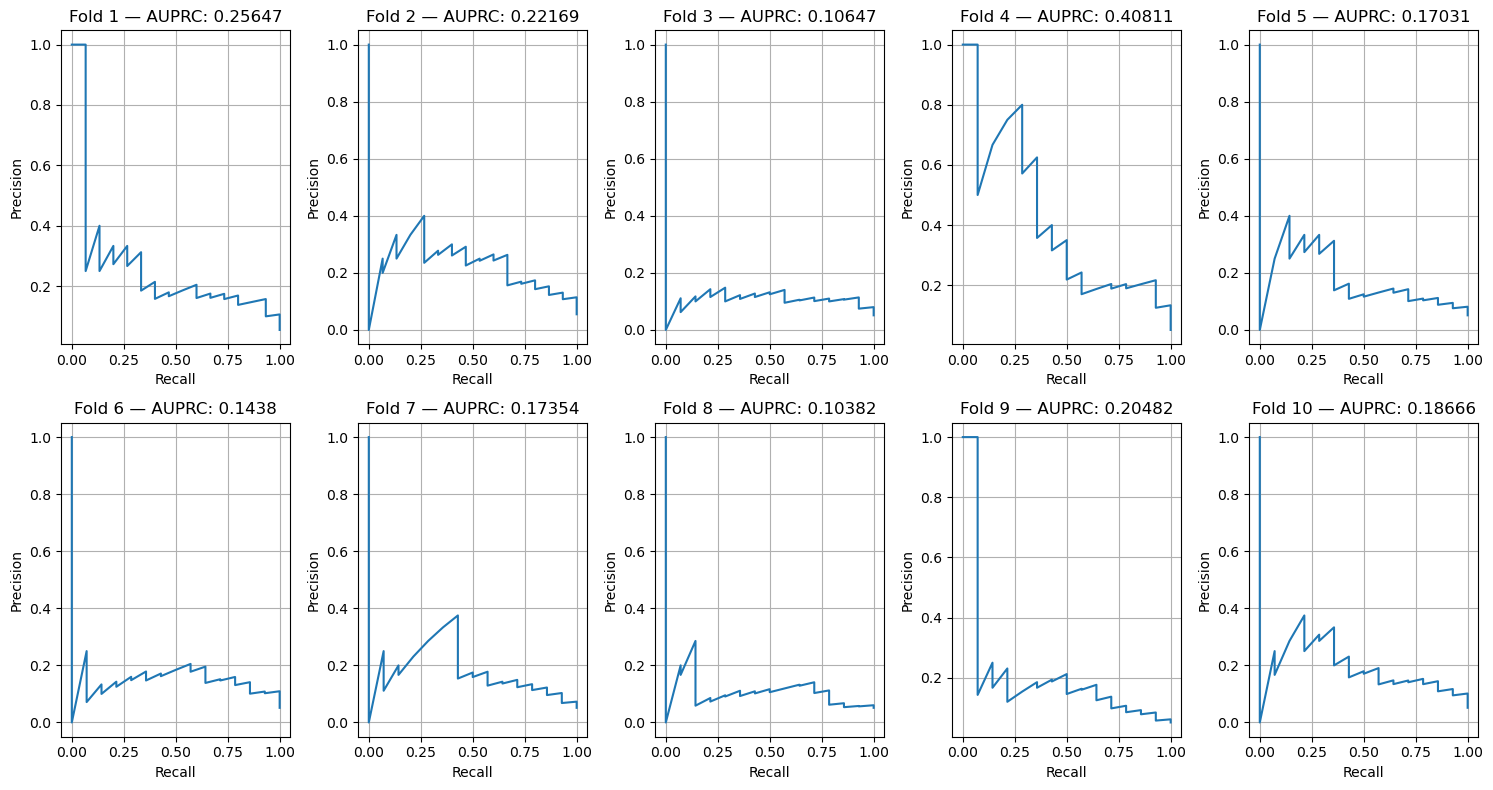


Mean AUPRC across 10 folds: 0.19757


In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

rf_precision = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=200, min_samples_leaf=3, min_samples_split=2, max_depth=5)

rf_precision_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('baseline_model', rf_precision)
])

evaluate_pr_cross_val(rf_precision_pipeline, X_train, y_train, 10)

Overall, although hyperparameter tuning improved the performance of the feature selected model, the maximum AUPRC score still came from the full-feature tuned model. The performance gap between the models with and without feature selection widened after hyperparameter tuning, indicating that the seemingly unimportant excluded feature 'ever_married' became more informative as Random Forest was optimised. 

Therefore, I can confidently say that the tuned model is the most effective, and will apply it on the test data. 


# Prediction using Tuned Model

First, we can finally fit our final model to the full training set. Due to the inbalance in the stroke dataset, when I used classification threshold=0.5, the model predicts barely any positives. By lowering the threshold, we can flag more potential stroke cases without sacrificing too much precision - due to the context of our dataset this is best for medical decision making since false negatives are the worst outcome. I chose the threshold to maximise the F1 score, since it provides a balanced measure of precision and recall, tying in with our performance metric. 

In [19]:
y_proba_train_recall = rf_recall_pipeline.predict_proba(X_train)[:, 1]

tuned_recall = TunedThresholdClassifierCV(
    estimator=rf_recall_pipeline,
    scoring='recall',
    cv=cv,
    random_state=42
)

tuned_recall.fit(X_train, y_train)
rf_recall_pipeline.fit(X_train, y_train)

print("Optimal threshold for recall:", tuned_recall.best_threshold_)

testing_dataset = pd.read_csv('stroke_testing_dataset-copy.csv')
testing_dataset = remove_anomolies(testing_dataset)

X_test = testing_dataset.drop(['stroke', 'id'], axis=1)
y_test = testing_dataset['stroke']

y_proba_test = rf_recall_pipeline.predict_proba(X_test)[:, 1]

Optimal threshold for recall: 0.0


Oh no! 

Type I Error Rate (False Positive Rate):  0.0015
Type II Error Rate (False Negative Rate):  1.0


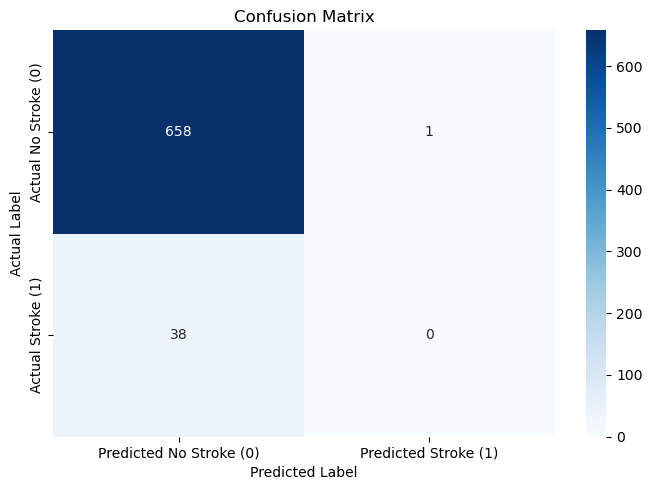

In [ ]:
y_pred_class = (y_proba_test >= tuned_recall.best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_class)
TN, FP, FN, TP = cm.ravel()

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Stroke (0)', 'Predicted Stroke (1)'],
            yticklabels=['Actual No Stroke (0)', 'Actual Stroke (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

type1_error_rate = FP / (FP + TN)
type2_error_rate = FN / (FN + TP)

print("Type I Error Rate (False Positive Rate): ", round(type1_error_rate, 4))
print("Type II Error Rate (False Negative Rate): ", round(type2_error_rate, 5))

In [ ]:
rf_precision_pipeline.fit(X_train, y_train)

y_proba_train_precision = rf_precision_pipeline.predict_proba(X_train)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_proba_train_precision)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_index = f1_scores.argmax()
best_threshold = thresholds[best_index]

print("Best threshold (training):", round(best_threshold, 3))

testing_dataset = pd.read_csv('stroke_testing_dataset-copy.csv')
testing_dataset = remove_anomolies(testing_dataset)

X_test = testing_dataset.drop(['stroke', 'id'], axis=1)
y_test = testing_dataset['stroke']

y_proba_test = rf_precision_pipeline.predict_proba(X_test)[:, 1]

Best threshold (training): 0.158


Type I Error Rate (False Positive Rate):  0.0319
Type II Error Rate (False Negative Rate):  0.71053


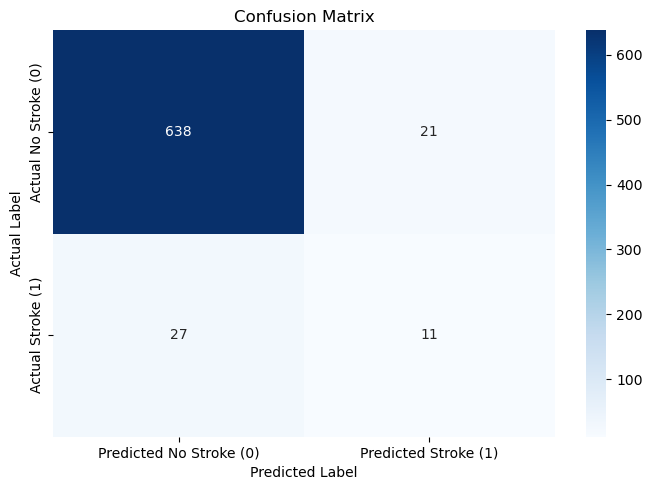

In [ ]:
y_pred_class = (y_proba_test >= best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_class)
TN, FP, FN, TP = cm.ravel()

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Stroke (0)', 'Predicted Stroke (1)'],
            yticklabels=['Actual No Stroke (0)', 'Actual Stroke (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

type1_error_rate = FP / (FP + TN)
type2_error_rate = FN / (FN + TP)

print("Type I Error Rate (False Positive Rate): ", round(type1_error_rate, 4))
print("Type II Error Rate (False Negative Rate): ", round(type2_error_rate, 5))

Our final AUPRC is much higher than the baseline RF result thanks to model refinement using hyperparameter training. Finally, I will generate a confusion matrix to find the distribution of type 1 and type 2 errors - another way to compare RF against the other models in my group.